##  Decision Trees for Regression

We can build decision trees for regression just like we built regression trees for classification.  The primary difference is the response is numeric for a regression tree.  This means that trees are split on a different metric than *gini impurity* which we used for classification trees.  Below we will use *mean squared error* which is the default to make our splits/branches but there are other choices available such as *mean absolute error*.

One thing to emphasis about decision trees is that the features much be numeric.  That means if we have categorical features/predictors/covariates that we will have to create indicators or one-hot encoded values for those features.

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from matplotlib import colors
import seaborn as sns

import scipy.stats as stats


from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

In [2]:
# read in the data to dataframe called ames
ames = pd.read_csv("https://webpages.charlotte.edu/mschuck1/classes/DTSC2301/Data/Ames_house_prices.csv", na_values=['?'])
# replace the ? in the data with NaN for missing values
ames.replace([' ?'],np.nan)
# show information about the dataframe
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
y=ames['SalePrice']
#ames=ames.drop('SalePrice', axis=1)
# we have to have numeric predictors for a decision tree
X=ames[['LotFrontage','LotArea','ScreenPorch','MoSold','YearBuilt','YearRemodAdd', 'BsmtFinSF1','OpenPorchSF','PoolArea','1stFlrSF','2ndFlrSF','GrLivArea']]
print(X.head())

   LotFrontage  LotArea  ScreenPorch  MoSold  YearBuilt  YearRemodAdd  \
0         65.0     8450            0       2       2003          2003   
1         80.0     9600            0       5       1976          1976   
2         68.0    11250            0       9       2001          2002   
3         60.0     9550            0       2       1915          1970   
4         84.0    14260            0      12       2000          2000   

   BsmtFinSF1  OpenPorchSF  PoolArea  1stFlrSF  2ndFlrSF  GrLivArea  
0         706           61         0       856       854       1710  
1         978            0         0      1262         0       1262  
2         486           42         0       920       866       1786  
3         216           35         0       961       756       1717  
4         655           84         0      1145      1053       2198  


In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a regression tree model
dtree = DecisionTreeRegressor(random_state=0)

# Train the model
dtree.fit(X_train, y_train)

# Make predictions
predictions = dtree.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Mean Squared Error: {rmse}")

Mean Squared Error: 52093.0961375748


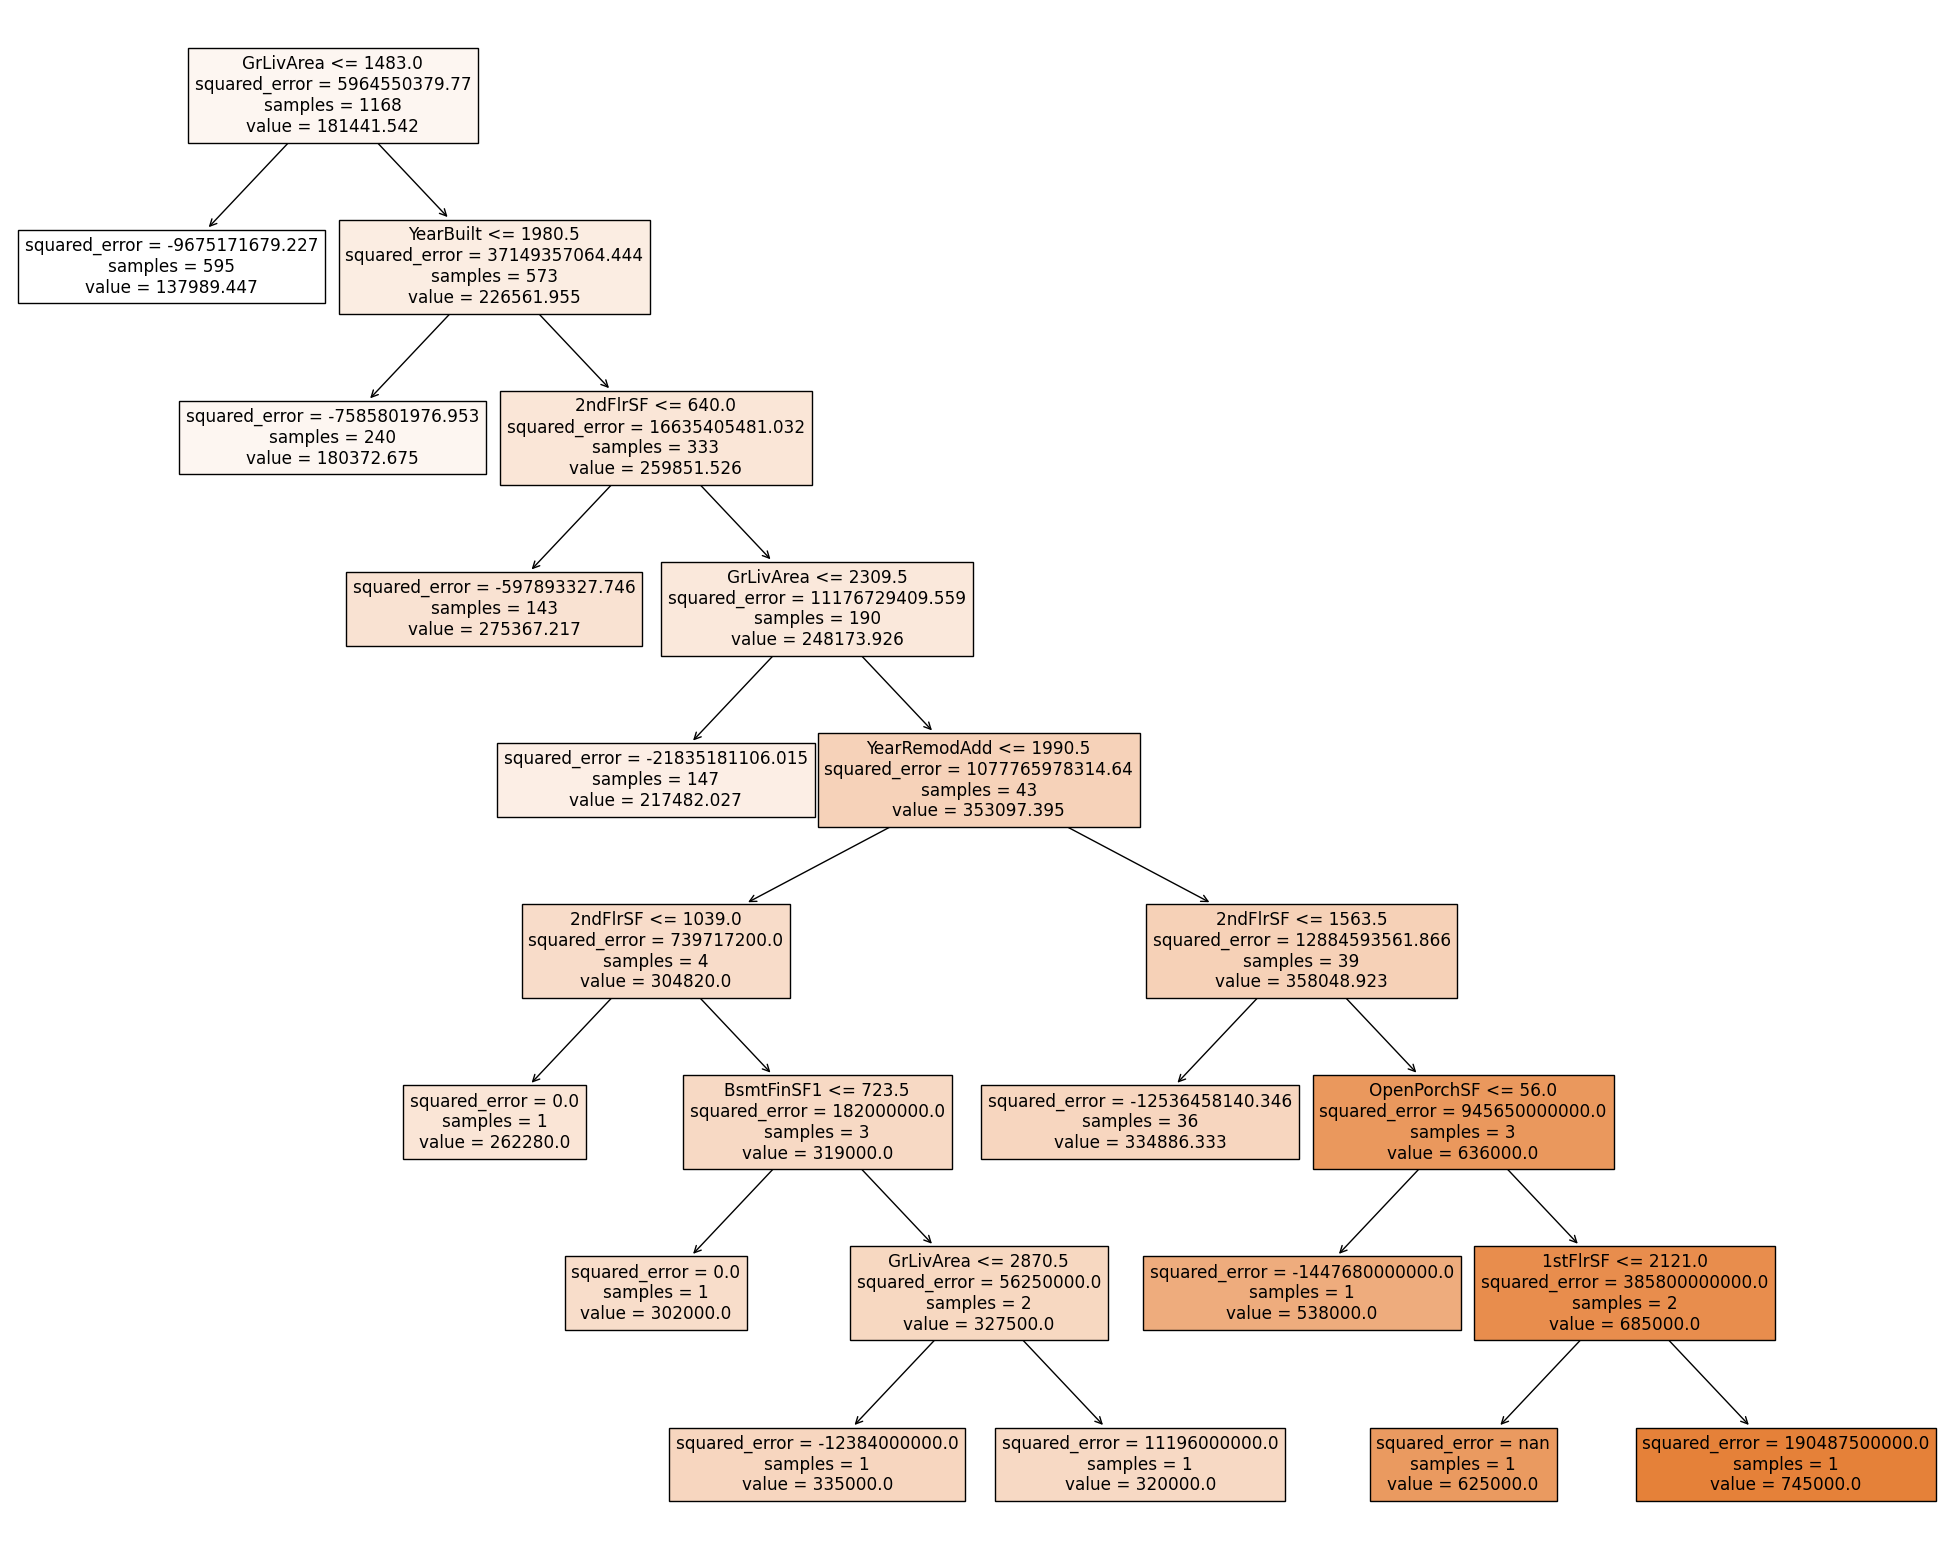

In [9]:
# create a plot of the decision tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dtree,
                   feature_names=['LotFrontage','LotArea','ScreenPorch','MoSold','YearBuilt','YearRemodAdd', 'BsmtFinSF1','OpenPorchSF','PoolArea','1stFlrSF','2ndFlrSF','GrLivArea'],
                   filled=True)
feature_names=['LotFrontage','LotArea','ScreenPorch','MoSold','YearBuilt','YearRemodAdd', 'BsmtFinSF1','OpenPorchSF','PoolArea','1stFlrSF','2ndFlrSF','GrLivArea']

Whoo-boy. That is a tree.  Perhaps we should prune that tree.

In [11]:
# initiate a decision tree with a max depth of 4
dt_pre_pruned = DecisionTreeRegressor(max_depth=4, min_samples_split=5, min_samples_leaf=2)

# Train the model
dt_pre_pruned.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=2, min_samples_split=5)

Let's get the feature importance for this model.  We'll use permutation importance for this model on the test data.

Reminder that the permutation importance is the amount that the model performance changes if we permute the values in that feature while keeping other features intact.    

In [10]:
# Permutation feature importance

result = permutation_importance(dt_pre_pruned, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
perm_imp_df = pd.DataFrame({'Feature': feature_names, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)
print(perm_imp_df)

         Feature  Permutation Importance
11     GrLivArea                0.574524
6     BsmtFinSF1                0.239685
4      YearBuilt                0.073510
7    OpenPorchSF                0.047817
0    LotFrontage                0.000000
1        LotArea                0.000000
2    ScreenPorch                0.000000
3         MoSold                0.000000
5   YearRemodAdd                0.000000
8       PoolArea                0.000000
9       1stFlrSF                0.000000
10      2ndFlrSF                0.000000


The values we get here make a good bit of sense as to the value of a house from my perspective.  *GrLivArea* is the amount of above grade (above ground?) living space and
the age of a house, *YearBuilt*, certainly have impacts on prices for houses.  


In [12]:
# Make predictions
predictions = dt_pre_pruned.predict(X_test)
 
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Mean Squared Error: {rmse}")

Mean Squared Error: 56961.2194892303


[Text(0.2857142857142857, 0.9, 'GrLivArea <= 1483.0\nsquared_error = 5964550379.77\nsamples = 1168\nvalue = 181441.542'),
 Text(0.14285714285714285, 0.7, 'squared_error = -14391326347.265\nsamples = 595\nvalue = 137989.447'),
 Text(0.42857142857142855, 0.7, 'YearBuilt <= 1980.5\nsquared_error = 51627500915.735\nsamples = 573\nvalue = 226561.955'),
 Text(0.2857142857142857, 0.5, 'squared_error = -4322522622.389\nsamples = 240\nvalue = 180372.675'),
 Text(0.5714285714285714, 0.5, 'GrLivArea <= 2309.5\nsquared_error = 13838700562.987\nsamples = 333\nvalue = 259851.526'),
 Text(0.42857142857142855, 0.3, 'squared_error = -14446795379.238\nsamples = 283\nvalue = 241786.643'),
 Text(0.7142857142857143, 0.3, 'GrLivArea <= 2330.5\nsquared_error = 6992344520258.0\nsamples = 50\nvalue = 362098.76'),
 Text(0.5714285714285714, 0.1, 'squared_error = 1710649600.0\nsamples = 2\nvalue = 303640.0'),
 Text(0.8571428571428571, 0.1, 'squared_error = 11947102989.332\nsamples = 48\nvalue = 364534.542')]

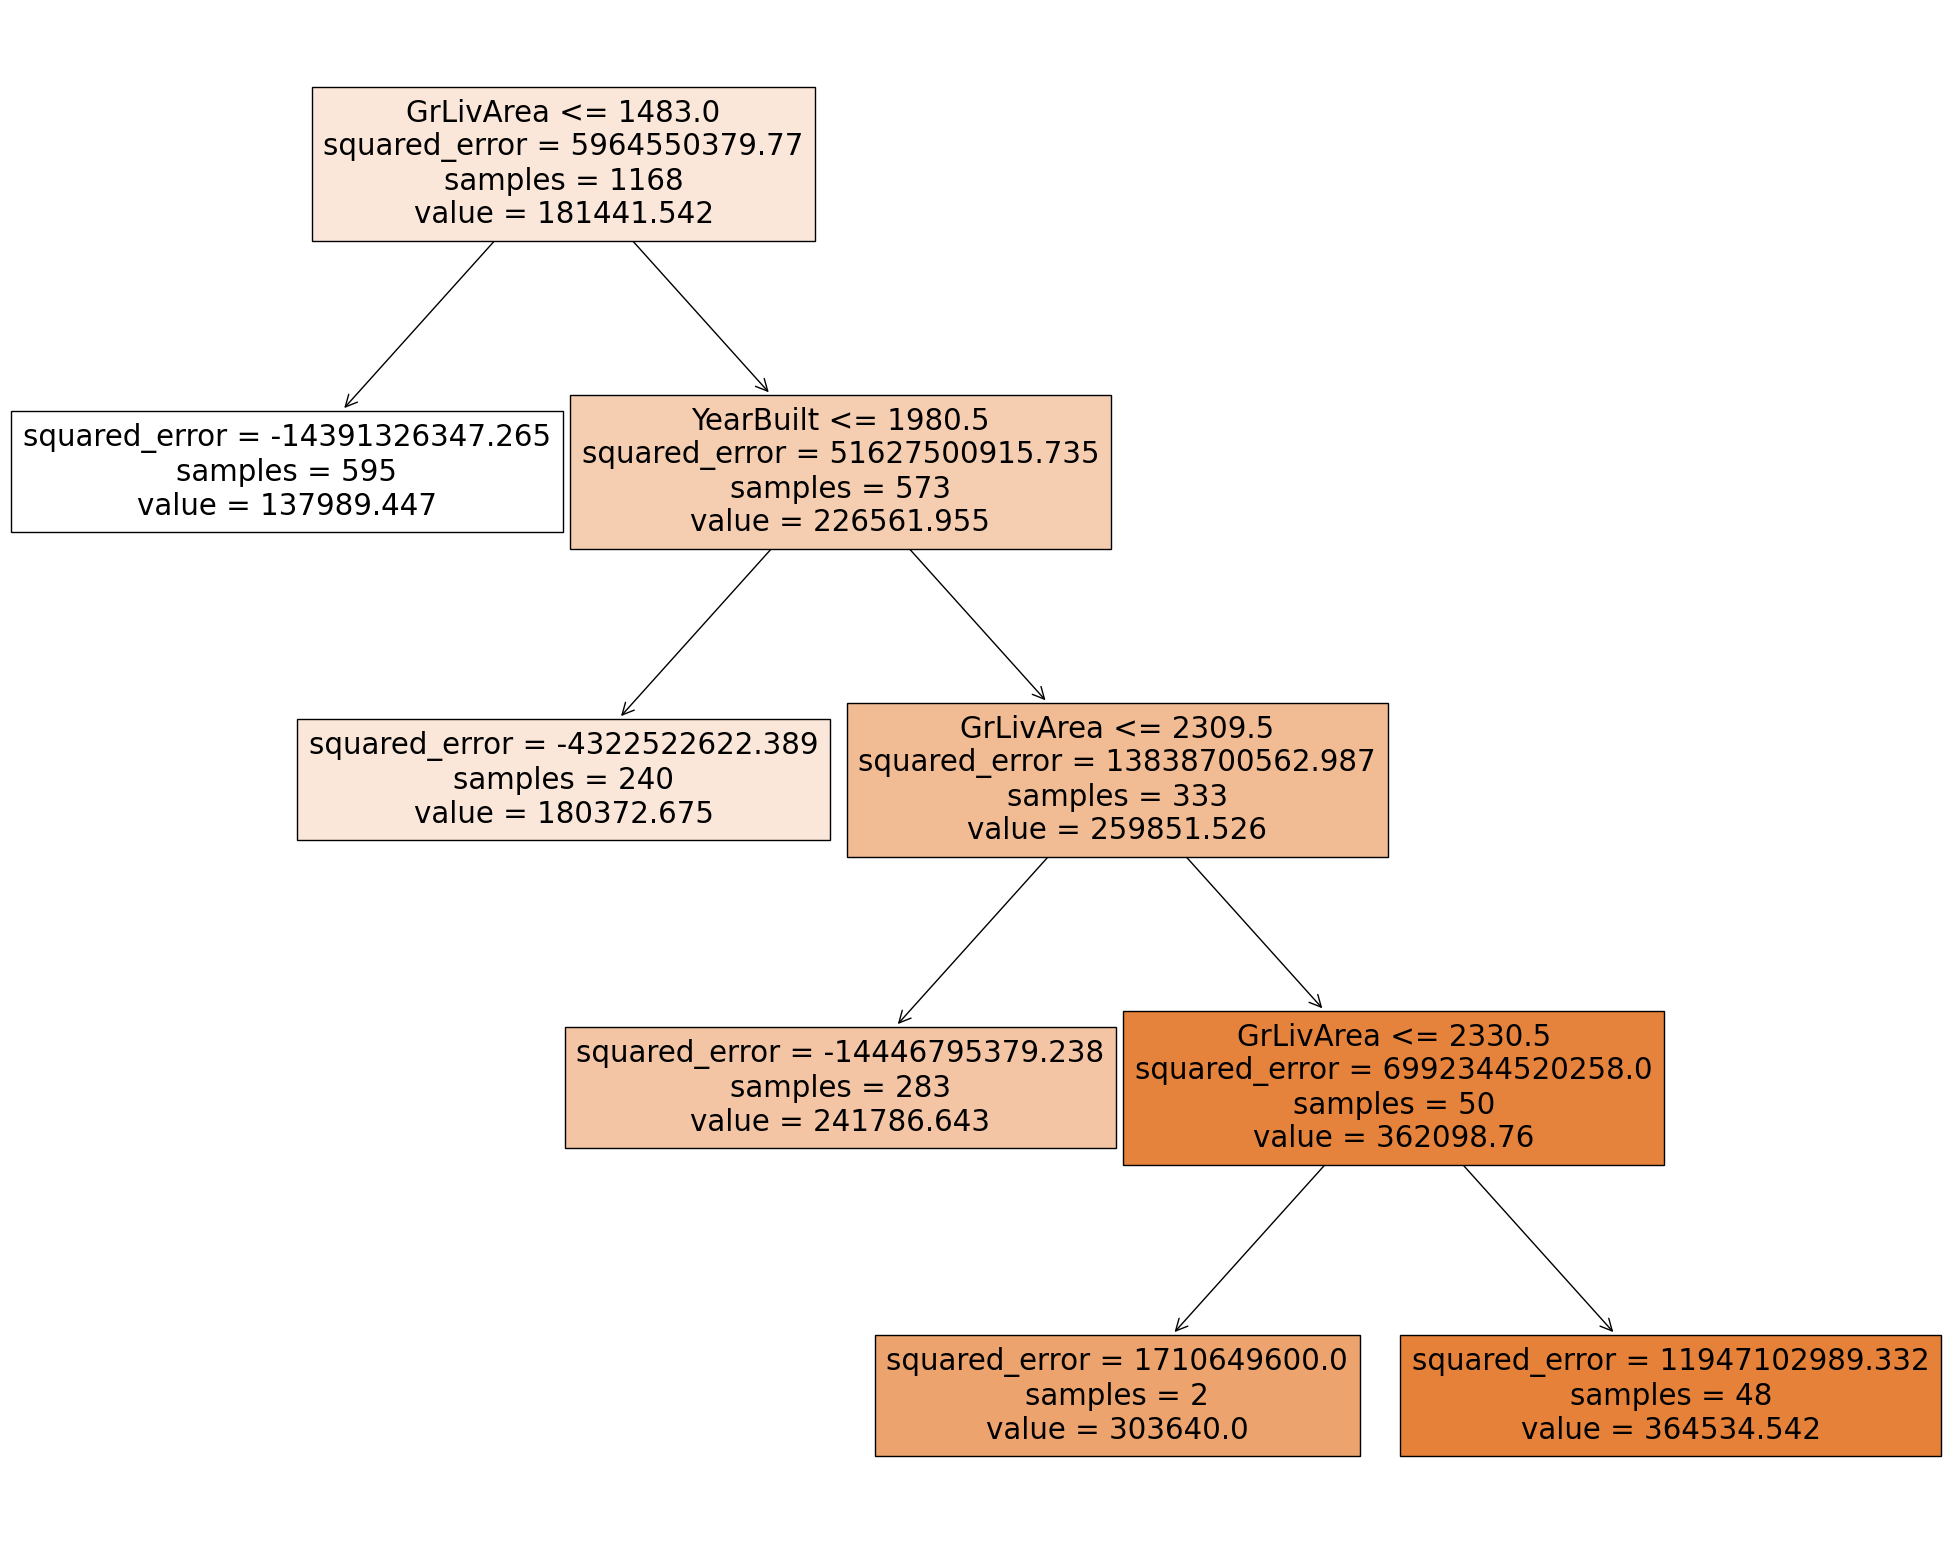

In [13]:

fig = plt.figure(figsize=(25,20))
tree.plot_tree(dt_pre_pruned,
                   feature_names=['LotFrontage','LotArea','ScreenPorch','MoSold','YearBuilt','YearRemodAdd', 'BsmtFinSF1','OpenPorchSF','PoolArea','1stFlrSF','2ndFlrSF','GrLivArea'],
                   filled=True)

Our out of sample performance is not as good but let's try something smaller.

In [14]:
dt_pre_pruned2 = DecisionTreeRegressor(max_depth=2, min_samples_split=5, min_samples_leaf=2)

# Train the model
dt_pre_pruned2.fit(X_train, y_train)
# Make predictions
predictions = dt_pre_pruned2.predict(X_test)
 

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Mean Squared Error: {rmse}")

Mean Squared Error: 64228.76207238542


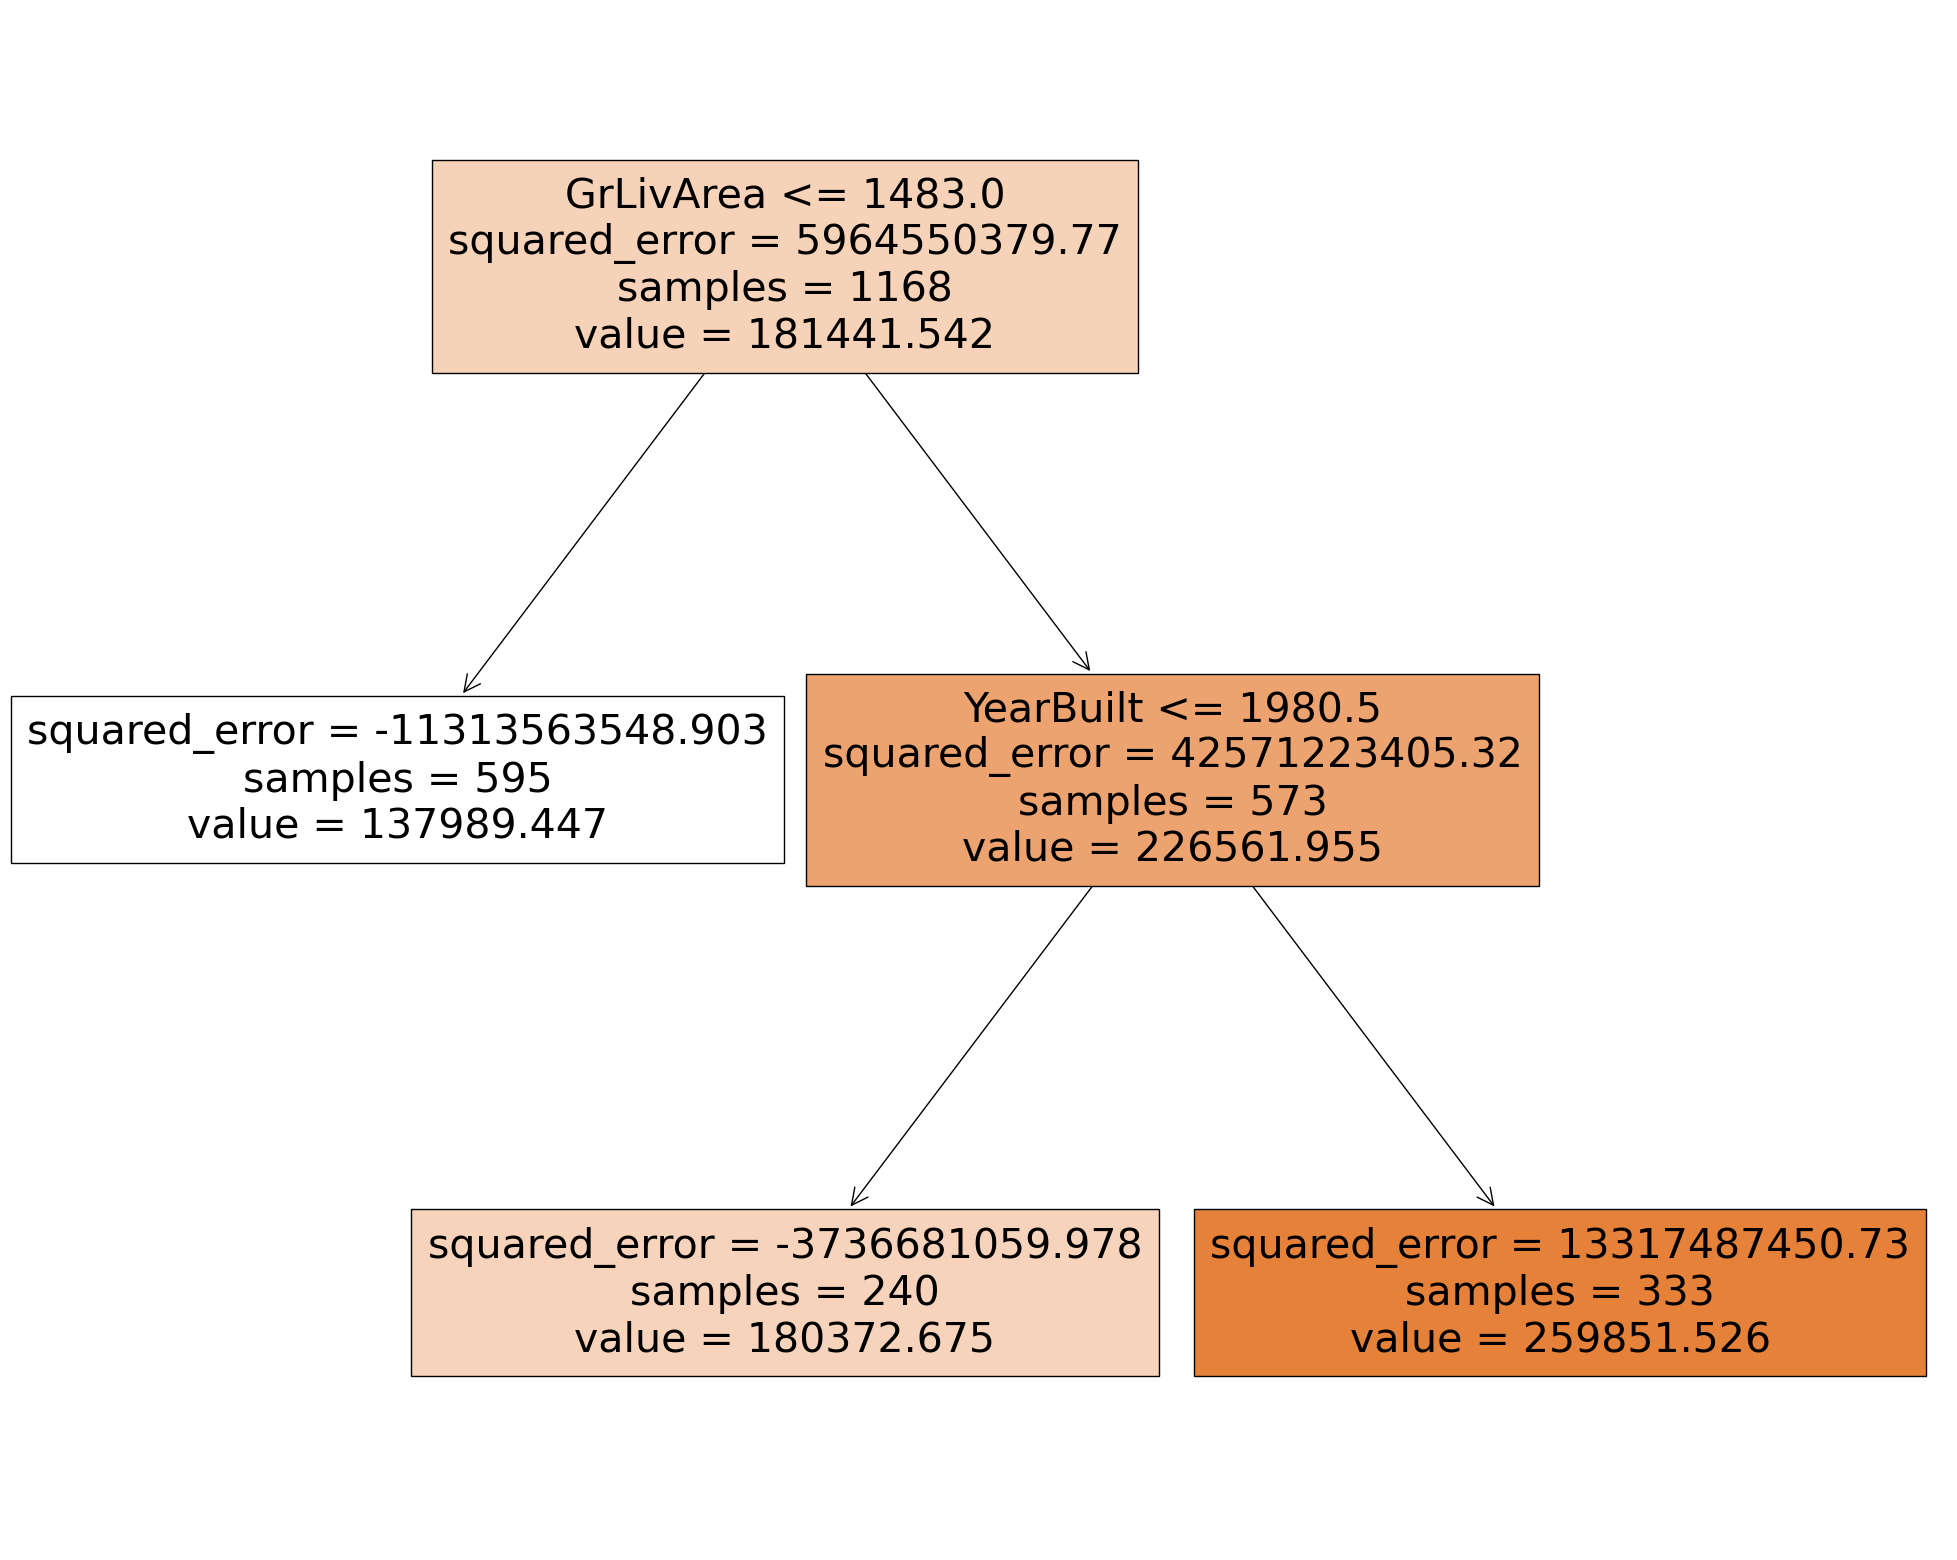

In [15]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dt_pre_pruned2,
                   feature_names=['LotFrontage','LotArea','ScreenPorch','MoSold','YearBuilt','YearRemodAdd', 'BsmtFinSF1','OpenPorchSF','PoolArea','1stFlrSF','2ndFlrSF','GrLivArea'],
                   filled=True)
feature_names=['LotFrontage','LotArea','ScreenPorch','MoSold','YearBuilt','YearRemodAdd', 'BsmtFinSF1','OpenPorchSF','PoolArea','1stFlrSF','2ndFlrSF','GrLivArea']

So with that depth we did not get a better tree but we did get one we can visualize.

Let's look at the cross-validation rather than a single test set.  We'll use 8-fold CV and we'll look at trees with depth 2 and depth 4.

In [16]:
dt_pre_pruned3 = DecisionTreeRegressor(max_depth=2, min_samples_split=5, min_samples_leaf=2)
cv_scores_tree3 = cross_val_score(dt_pre_pruned3, X, y, cv=8, scoring='neg_root_mean_squared_error')  # 8-fold cross-validation
print(f"RBF Kernel SVM cross-validation accuracy: {cv_scores_tree3.mean() :.2f}")

RBF Kernel SVM cross-validation accuracy: -65737.61


In [17]:
dt_pre_pruned3 = DecisionTreeRegressor(max_depth=4, min_samples_split=5, min_samples_leaf=2)
cv_scores_tree3 = cross_val_score(dt_pre_pruned3, X, y, cv=8, scoring='neg_root_mean_squared_error')  # 8-fold cross-validation
print(cv_scores_tree3)
print(f"RBF Kernel SVM cross-validation accuracy: {cv_scores_tree3.mean() :.2f}")

[-52678.01708986 -62129.72010983 -56325.41658364 -68609.00430056
 -57321.25010905 -53893.00648426 -61334.56581081 -54412.40358253]
RBF Kernel SVM cross-validation accuracy: -58337.92


So from above we can see that the larger tree with *max_depth=4* performed better on cross-validation.  Below is code to determine the
best *max_depth* via cross-validation. 

In [18]:
sizes = 12

# create an empty array to store the calculated mean RMSEs
aver_rmse = []
depth=list(range(1,13,1))
# loop through the different pruning sizes
for i in range(sizes):
  # create a pruned tree of size i+1
  dt_pruned = DecisionTreeRegressor(max_depth=i+1, min_samples_split=5, min_samples_leaf=2)
  # calculate the negative RMSE, why python insists on the negative here I do not know
  # ...
  # well...
  # actually I have a guess.  I'm guessing that the algorithm is set to maximize a quantity
  # such as r^2.  And maximizing -RMSE is the same as minimizing RMSE
  cv_scores_tree = cross_val_score(dt_pruned, X, y, cv=8, scoring='neg_root_mean_squared_error')
  # get the average from the 8-fold cross validations and multiply by -1 to get back to the right scale. 
  avg = -1*cv_scores_tree.mean()
  # add avg to the list of other bootstrapped means
  aver_rmse.append(avg)


In [19]:
# look at the values
print(aver_rmse)

[66430.84835759716, 64467.29443568367, 61407.44693834073, 56965.40639398676, 58033.53468672517, 57885.14503238944, 57927.82485483601, 59710.072603526925, 57668.39370288122, 59472.973280308215, 56666.94859351621, 59364.81145275548]


Let's look at a plot of these cross validated RMSE's to get a better sense of these.

Text(0.5, 0, 'prune depth')

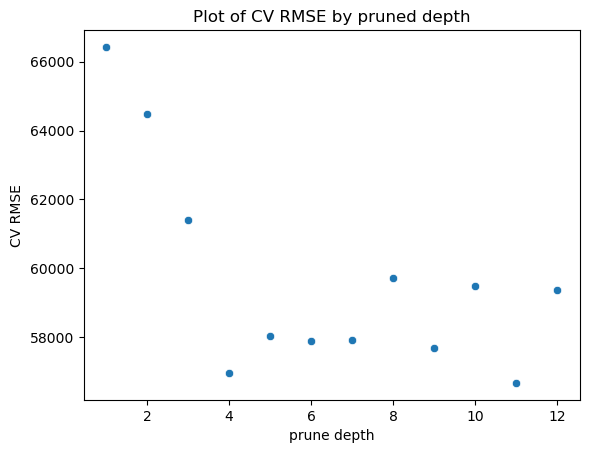

In [20]:
# make a scatterplot for depth vs average RMSE
ax=sns.scatterplot(x=depth, y=aver_rmse)
# "ax" is the conventional name.
ax.set_title('Plot of CV RMSE by pruned depth')
ax.set_ylabel('CV RMSE')
ax.set_xlabel('prune depth')


It looks like the 'best' performing prune depth is 7 or 8 or 9.  I'd prefer the smallest model here so that seems to be *7*.  



### Forests from Trees

The next cells of code move from regression decision trees to regression random forests.

In [ ]:


# Train Random Forest Regressor with maximum depth of 3 
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
# get the 8 fold cross validation score
scores = -1*cross_val_score(rf_regressor, X, y, cv=8, scoring='neg_root_mean_squared_error')
print(scores.mean())

41954.955570823746


So the above output was from making many trees with just a depth of 3.  Note that the average RMSE from our plot above with a prune depth of *3* was about 50000.  We got a good bit smaller RMSE by using a random forest of the same size.


In [24]:
# Train Random Forest Regressor with maximum depth of 3 
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
# get the 8 fold cross validation score
scores = -1*cross_val_score(rf_regressor, X, y, cv=8, scoring='neg_root_mean_squared_error')
print(scores.mean())

ValueError: 
All the 8 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tommie-clark/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tommie-clark/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tommie-clark/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py", line 348, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/tommie-clark/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tommie-clark/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1147, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/home/tommie-clark/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/home/tommie-clark/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/home/tommie-clark/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


From that result, we can see that a random forest with a depth of *4* continues our improvement over having a depth of *3*.  In the Tasks below, you'll create a loop for
determining the 'best' value based upon cross-validation.

### Tasks

1. Write code to determine the best *max_depth* for a regression random forest for these data.  Make a plot like we did above to visualize the output.



2. Determine the permutation importance for the best regression random forest based upon your results from above.



3. Choose a subset of features/predictors from your results in Task 2.  Rerun the code for Tasks 1 and 2 with these new predictors.  Does your CV RMSE change?  If so, how?